**MSBA 6410: Exploratory Data Analysis & Visualization**

<br>

**Authors:** Sarah Black, Michael DeGuire, Anthony Meyers, Danny Moncada, and Jonathan Watkins 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-Statement-and-Approach" data-toc-modified-id="Problem-Statement-and-Approach-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Problem Statement and Approach</a></span><ul class="toc-item"><li><span><a href="#Sun-Countries-Objectives" data-toc-modified-id="Sun-Countries-Objectives-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Sun Countries Objectives</a></span></li><li><span><a href="#Our-Approach" data-toc-modified-id="Our-Approach-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Our Approach</a></span></li></ul></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#Exploratory-Analysis" data-toc-modified-id="Exploratory-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploratory Analysis</a></span></li><li><span><a href="#Clustering-Strategies-Towards-Customer-Segmentation" data-toc-modified-id="Clustering-Strategies-Towards-Customer-Segmentation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Clustering Strategies Towards Customer Segmentation</a></span><ul class="toc-item"><li><span><a href="#Characteristics-of-UFly-Reward-members" data-toc-modified-id="Characteristics-of-UFly-Reward-members-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Characteristics of UFly Reward members</a></span></li><li><span><a href="#Characteristics-of-Fliers" data-toc-modified-id="Characteristics-of-Fliers-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Characteristics of Fliers</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#Recommendations" data-toc-modified-id="Recommendations-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Recommendations</a></span></li></ul></div>

# Problem Statement and Approach

## Sun Countries Objectives

In order to compete with major airline firms, Sun Country Airlines needs to be savvy and sophisticated in their marketing and customer interaction strategy. Sun Countries Ufly reward program and digital experience provide Sun Country a platform in which to enable modern marketing and analytics techniques to create value to enable Sun Country to compete with other, more resource enabled, airline firms. Leveraging exploratory analytics techniques, such as clustering analysis, will enable Sun Country to generate insights and actionable hypotheses from the data. Examining the characteristics of customer cohorts and their flying habits will help Sun Counry focus their strategic initiatives to delivering best in class service and options to the Sun Country customer base.

## Our Approach

We propose a customer segmentation analytics approach to guide the exploration of customer characteristics and how they travel. Specifically, we choose to explore the portion of customer who use the Minneapolis - St.Paul Sun Country hub as their start point for their journeys, as coded in the data. We then leverage a k-medioids approach to cluster mixed data-types. This partioning around mediods algorithm leverages Gower distance to appropriately compute partial dissimilarities and is very intuitive. It also has an extremely useful feature in that it can produce statistics around what a typical customer might look like for each cluster, allowing us to see who is, or isn't, traveling with a UFly membership or booking through the SCA site.

# Data Preparation

In [1]:
# Importing Packages
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(cluster))
suppressPackageStartupMessages(library(Rtsne))
suppressPackageStartupMessages(library(lubridate))

# Numeric Formatting
options(scipen = 999)

# Import and parse data
suppressWarnings(suppressMessages(df <- readr::read_csv(file = "~/Downloads/HW 2/SunCountry.csv")))

# Initial Review of Data
str(df)

Classes ‘spec_tbl_df’, ‘tbl_df’, ‘tbl’ and 'data.frame':	3435388 obs. of  26 variables:
 $ PNRLocatorID        : chr  "AAABJK" "AAABJK" "AAABMK" "AAABMK" ...
 $ TicketNum           : num  3377365159634 3377365159634 3372107381942 3372107381942 3372107470782 ...
 $ CouponSeqNbr        : num  2 1 2 1 1 1 1 1 1 1 ...
 $ ServiceStartCity    : chr  "JFK" "MSP" "MSP" "SFO" ...
 $ ServiceEndCity      : chr  "MSP" "JFK" "SFO" "MSP" ...
 $ PNRCreateDate       : Date, format: "2013-11-23" "2013-11-23" ...
 $ ServiceStartDate    : Date, format: "2013-12-13" "2013-12-08" ...
 $ PaxName             : chr  "BRUMSA" "BRUMSA" "EILDRY" "EILDRY" ...
 $ EncryptedName       : chr  "4252554D4241434B44696420493F7C20676574207468697320726967687453414E445241204C4545" "4252554D4241434B44696420493F7C20676574207468697320726967687453414E445241204C4545" "45494C4445525344696420493F7C2067657420746869732072696768745259414E204C" "45494C4445525344696420493F7C2067657420746869732072696768745259414E204C" ...
 $ GenderCode 

To understand our data and verify the accuracy of our parsed data types, we first examined the structure of our data frame. While the *read_csv* function parsed our numeric and date fields correctly, we decided to convert several of our "character" fields to "factors" to satisfy the parameter requirements for the clustering algorithm. Additionally, we also chose to create several re-binned date fields to facilitate our analyses.

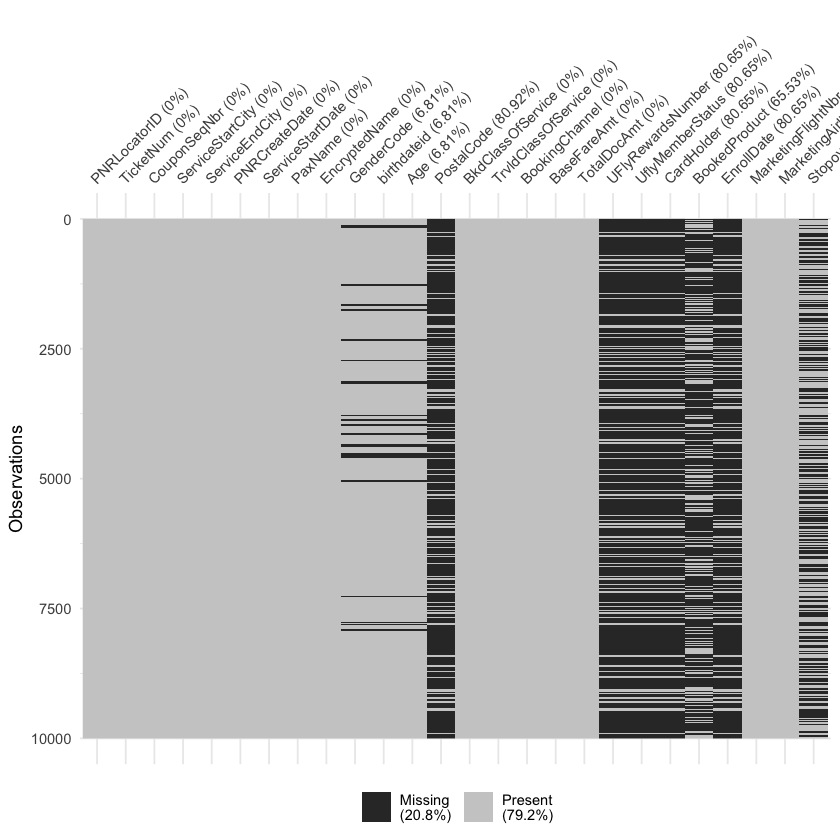

In [2]:
# Checking for Missing Values
naniar::vis_miss(head(df, 10000), warn_large_data=FALSE)

**Missing Values**
<br>
Within our data preparation, we examined our data for missing values. Through this process, we discovered a substantial number of missing values among a relatively small number of data fields, including UFly Member Status, Cardholder, and Enrollment Date. To resolve missing UFly data, we recoded missing values to reflect non-member/cardholder status. 

To address the (lesser) issue of missing Age and Gender data, where only 6.8% of values were found to be missing, we decided to forgo the imputation process and drop those values as necessary to satisfy the parameter requirements for the clustering algorith.

In [3]:
# Reformatting Data
suppressWarnings(df <- df %>% 
mutate(UflyMemberStatus = case_when(
    UflyMemberStatus=="Standard"~"Standard",
    UflyMemberStatus=="Elite"~"Elite",
    is.na(UflyMemberStatus)==TRUE~"Non-Member")) %>% 
mutate(PNRCreateMonth = month(PNRCreateDate),
       ServiceStartMonth = month(ServiceStartDate)) %>% 
mutate(PNRCreateSeason = case_when(
    PNRCreateMonth %in% c(11, 12, 1, 2, 3) ~ "Winter",
    PNRCreateMonth %in% c(4, 5) ~ "Spring",
    PNRCreateMonth %in% c(6, 7, 8) ~ "Summer",
    PNRCreateMonth %in% c(9, 10) ~ "Fall"),
       ServiceStartSeason = case_when(
           ServiceStartMonth %in% c(11, 12, 1, 2, 3) ~ "Winter",
           ServiceStartMonth %in% c(4, 5) ~ "Spring",
           ServiceStartMonth %in% c(6, 7, 8) ~ "Summer",
           ServiceStartMonth %in% c(9, 10) ~ "Fall")) %>% 
mutate(EnrollDate = ymd_hms(EnrollDate),
       EnrollDate = dmy(paste0("15-",month(EnrollDate),"-",year(EnrollDate)))))

Here, we have implement several of the recoding and variable changes described above. The function, *flight_legs*, shown below allowed us to tidy our data to display a single ticket observation per line by preserving our repeated customer data and combining our trip legs onto a single line.

In [4]:
flight_legs <- function(dataframe_in) {
    a <- dataframe_in %>% 
    select(PNRLocatorID, TicketNum, CouponSeqNbr, ServiceStartCity, 
           ServiceEndCity) %>% 
    group_by(TicketNum) %>% mutate(trip_max = max(CouponSeqNbr))
    a1 <- a %>% filter(CouponSeqNbr == 1) %>% 
    select(PNRLocatorID, TicketNum, ServiceStartCity, ServiceEndCity, 
           trip_max) %>% 
    rename(City1 = ServiceStartCity, City2 = ServiceEndCity)
    a2 <- a %>% filter(CouponSeqNbr == 2) %>% 
    select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
    rename(City3 = ServiceEndCity)
    a3 <- a %>% filter(CouponSeqNbr == 3) %>% 
    select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
    rename(City4 = ServiceEndCity)
    a4 <- a %>% filter(CouponSeqNbr == 4) %>% 
    select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
    rename(City5 = ServiceEndCity)
    a5 <- a %>% filter(CouponSeqNbr == 5) %>% 
    select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
    rename(City6 = ServiceEndCity)
    a6 <- a %>% filter(CouponSeqNbr == 6) %>% 
    select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
    rename(City7 = ServiceEndCity)
    jc <- c("trip_max" = "trip_max", "PNRLocatorID"="PNRLocatorID", 
            "TicketNum"="TicketNum")
    j1 <- left_join(a1, a2, by=jc); rm(a1, a2)
    j2 <- left_join(j1, a3, by=jc); rm(j1, a3)
    j3 <- left_join(j2, a4, by=jc); rm(j2, a4)
    j4 <- left_join(j3, a5, by=jc); rm(j3, a5)
    j5 <- left_join(j4, a6, by=jc) %>% 
    select(PNRLocatorID, TicketNum, trip_max, 
           City1, City2, City3, City4, City5, 
           City6, City7)
    j5 <- j5 %>% 
        mutate(mid_dest = case_when(
            trip_max==1~City2, trip_max==2~City2,
            trip_max==3~"Ambiguous", trip_max==4~City3,
            trip_max==5~"Ambiguous", trip_max==6~City4))
    jx <- as_tibble(j5) %>% 
    unite("Airport_Sequence", City1:City7, sep = "->", na.rm = TRUE)
    jx <- jx[!duplicated(jx),]
    return(jx)}

In [5]:
# Transforming our Data (Note: This step takes some time.)
df <- left_join(df %>% filter(CouponSeqNbr == 1) , flight_legs(df), by = c("PNRLocatorID", "TicketNum")) 

In [6]:
dim(df)

[1] 1951244      33

Here, we have reduced the volume of data from 3,435,388 rows to 1,951,244 rows by transforming our data to reflect a single customer ticket per row. Within the missing value table below, we have resolved our most pertinent missing UFly data. The remaining missing values were addressed on an ad hoc basis. 

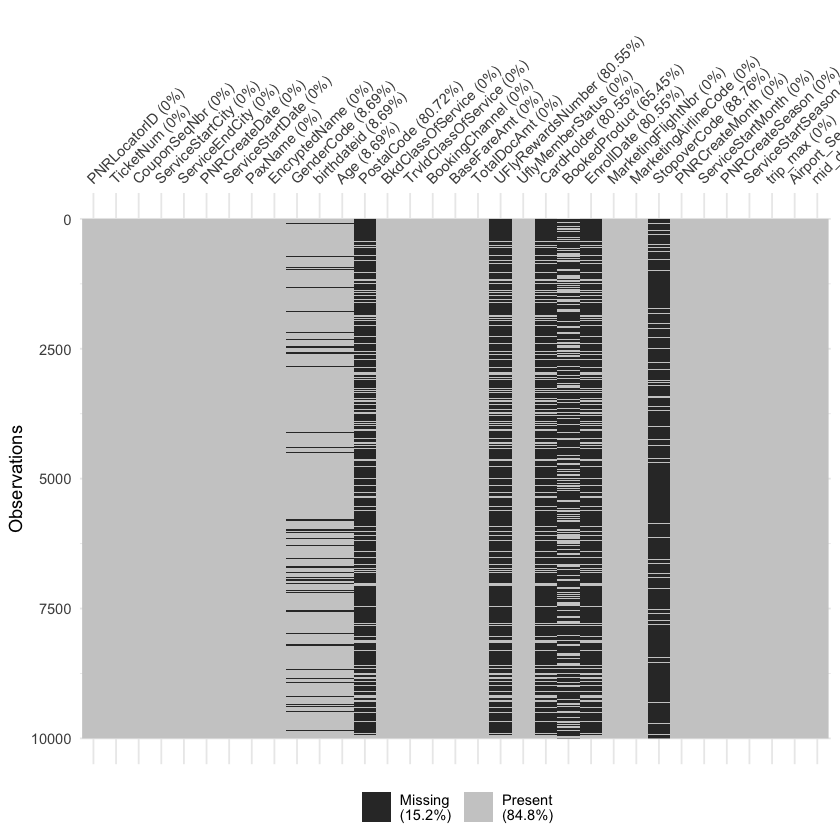

In [7]:
naniar::vis_miss(head(df, 10000), warn_large_data=FALSE)

# Exploratory Analysis



We found # Clusters - brief description

One particular cluster of interest was Men in their 50's who fly from Minneapolis to Las Vegas in coach, booking via the Sun Country Website, that are not Ufly Rewards members or credit card holders. Minneapolis to Las Vegas is a very popular flight for Sun Country and is offered frequently and this group of flyers in particular stands out. This customer segment is already booking through the website so an extra push to get them to be Ufly Rewards members may help to get them to make more trips on Sun Country.


# Clustering Strategies Towards Customer Segmentation

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(cluster))
suppressPackageStartupMessages(library(factoextra))
suppressPackageStartupMessages(library(corrplot))
suppressPackageStartupMessages(library(PerformanceAnalytics))

In [2]:
## Set the working directory
## This can be changed based on where you have your data

data.dir = "C:/Users/monca016/Documents/Fall 2019/MSBA 6410 - Exploratory Analytics/HW2/"


## Set the file name
data.file = "SunCountry_MSPDepartures_20kSample_wCluster.csv"


cluster_data = read.csv(paste(data.dir, data.file, sep = ""))

In [3]:
gower = daisy(cluster_data, metric = "gower")

dissimilarity.mtrx.csv.content = as.matrix(gower)

write.table(dissimilarity.mtrx.csv.content,
           'dissimilarity.mtrx.csv',
           row.names=FALSE,
           col.names=FALSE,
           sep=",")

Warning message in daisy(cluster_data, metric = "gower"):
"binary variable(s) 9, 10 treated as interval scaled"

ERROR: Error in eval(lhs, parent, parent): object 'data_feats_sample' not found


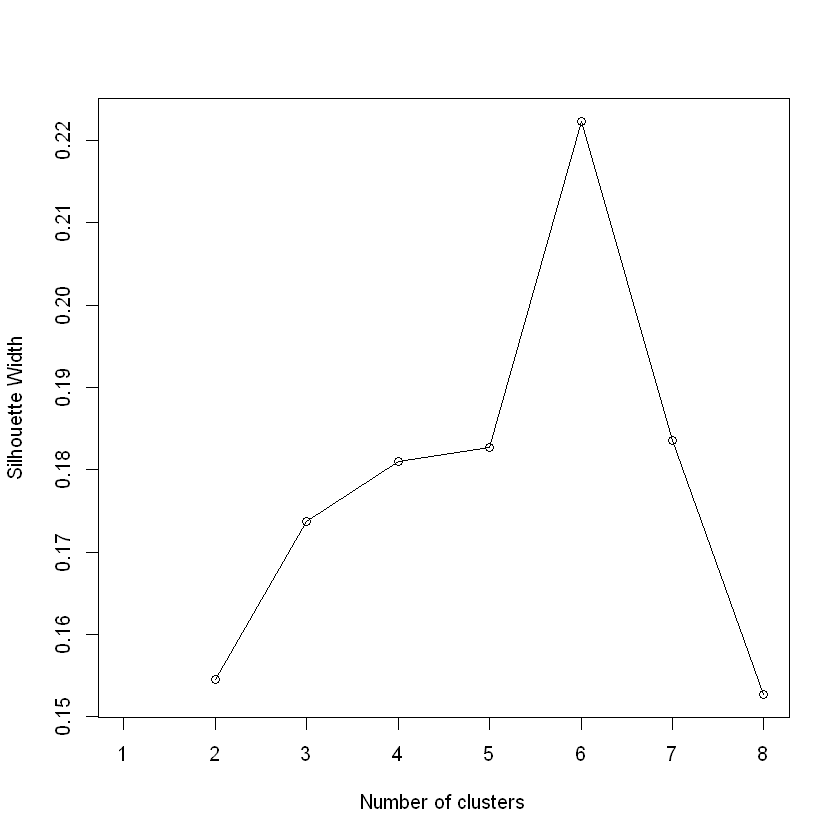

In [4]:
## gower = daisy(cluster_data, metric = "gower")

#find similar characteristics
#data_feats_sample[which(gower_mat == min(gower_mat[gower_mat != min(gower_mat)]), arr.ind = TRUE)[1, ], ]

#find not similar characteristics
#data_feats_sample[which(gower_mat == min(gower_mat[gower_mat != max(gower_mat)]), arr.ind = TRUE)[1, ], ]

#determine a number of clusters ----------------
sil_width = c(NA)

for(i in 2:8){
  pam_fit = pam(gower, diss = TRUE, k = i)
  sil_width[i] = pam_fit$silinfo$avg.width
}

plot(1:8, sil_width,
     xlab = "Number of clusters",
     ylab = "Silhouette Width")
lines(1:8, sil_width)

#get a summary of the clusters ----------------

In [45]:
# k = 6
# pam_fit = pam(gower, diss = TRUE, k)
# pam_results = cluster_data %>%
#  mutate(cluster = pam_fit$clustering) %>%
#  group_by(cluster) %>%
#  do(the_summary = summary(.))
# pam_results$the_summary

In [70]:
## Output the clustering analysis to a CSV

#as.matrix(pam_results)

 pam_results_as_csv <- write.csv(as.matrix(pam_results), file = "ClusteringAnalysis_Output.csv")

In [49]:
pam_results$the_summary[[1]]

       id        ServiceStartCity ServiceEndCity GenderCode
 Min.   :    1   MSP:4001         MCO    : 806   F: 377    
 1st Qu.: 4793                    JFK    : 330   M:3624    
 Median : 9884                    SFO    : 319   U:   0    
 Mean   : 9907                    LAX    : 297             
 3rd Qu.:14869                    BOS    : 264             
 Max.   :19994                    LAS    : 244             
                                  (Other):1741             
              BookingChannel    TimeGap          TripMonth         Age        
 Outside Booking     :3239   Min.   :  0.00   December: 876   Min.   :  0.00  
 Reservations Booking: 334   1st Qu.: 17.00   July    : 348   1st Qu.: 21.00  
 SCA Website Booking : 224   Median : 40.00   June    : 338   Median : 31.00  
 Tour Operator Portal: 123   Mean   : 58.16   August  : 330   Mean   : 32.67  
 SY Vacation         :  61   3rd Qu.: 82.00   May     : 325   3rd Qu.: 44.00  
 MSP                 :  16   Max.   :482.00   

In [50]:
pam_results$the_summary[[2]]

       id        ServiceStartCity ServiceEndCity GenderCode
 Min.   :    2   MSP:1902         LAS    :335    F:  94    
 1st Qu.: 5002                    LAX    :141    M:1808    
 Median : 9928                    JFK    :131    U:   0    
 Mean   : 9941                    SFO    :131              
 3rd Qu.:15004                    BOS    :123              
 Max.   :19992                    MCO    :106              
                                  (Other):935              
              BookingChannel    TimeGap          TripMonth        Age        
 SCA Website Booking :1336   Min.   :  0.00   March   :300   Min.   :  0.00  
 Outside Booking     : 333   1st Qu.: 19.00   November:200   1st Qu.: 36.00  
 Reservations Booking: 129   Median : 45.00   October :182   Median : 48.00  
 SY Vacation         :  71   Mean   : 61.89   February:161   Mean   : 46.11  
 Tour Operator Portal:  25   3rd Qu.: 87.00   August  :150   3rd Qu.: 59.00  
 FCM                 :   8   Max.   :373.00   Januar

In [51]:
pam_results$the_summary[[3]]

       id        ServiceStartCity ServiceEndCity GenderCode
 Min.   :    3   MSP:4215         LAS    : 932   F:3951    
 1st Qu.: 4820                    JFK    : 326   M: 264    
 Median : 9982                    SEA    : 294   U:   0    
 Mean   : 9951                    SFO    : 285             
 3rd Qu.:14936                    CUN    : 276             
 Max.   :20000                    LAX    : 253             
                                  (Other):1849             
              BookingChannel    TimeGap          TripMonth         Age        
 Outside Booking     :3357   Min.   :  0.00   February: 964   Min.   :  0.00  
 Reservations Booking: 258   1st Qu.: 22.00   July    : 370   1st Qu.: 29.00  
 SCA Website Booking : 200   Median : 46.00   June    : 357   Median : 43.00  
 SY Vacation         : 195   Mean   : 61.91   October : 337   Mean   : 42.54  
 Tour Operator Portal: 189   3rd Qu.: 86.50   August  : 336   3rd Qu.: 55.00  
 MSP                 :  13   Max.   :507.00   

In [59]:
pam_results$the_summary[[4]]

       id        ServiceStartCity ServiceEndCity GenderCode
 Min.   :    4   MSP:3800         MCO    : 666   F:3760    
 1st Qu.: 5218                    LAX    : 276   M:  39    
 Median :10167                    SEA    : 257   U:   1    
 Mean   :10106                    JFK    : 253             
 3rd Qu.:15025                    SFO    : 224             
 Max.   :19988                    CUN    : 215             
                                  (Other):1909             
              BookingChannel    TimeGap         TripMonth         Age        
 SCA Website Booking :2842   Min.   :  0.00   March  :1054   Min.   :  0.00  
 Reservations Booking: 386   1st Qu.: 24.75   July   : 316   1st Qu.: 18.00  
 Outside Booking     : 251   Median : 53.00   June   : 294   Median : 32.00  
 Tour Operator Portal: 180   Mean   : 70.57   August : 288   Mean   : 34.04  
 SY Vacation         : 119   3rd Qu.:100.00   January: 281   3rd Qu.: 49.00  
 MSP                 :  14   Max.   :514.00   Octobe

In [58]:
pam_results$the_summary[[5]]

       id        ServiceStartCity ServiceEndCity GenderCode
 Min.   :   13   MSP:3720         LAS    : 817   F: 155    
 1st Qu.: 5138                    RSW    : 236   M:3565    
 Median :10024                    LAX    : 226   U:   0    
 Mean   :10058                    JFK    : 215             
 3rd Qu.:15102                    CUN    : 204             
 Max.   :19995                    PHX    : 189             
                                  (Other):1833             
              BookingChannel    TimeGap         TripMonth         Age       
 SCA Website Booking :2587   Min.   :  0.0   March   : 813   Min.   : 0.00  
 Outside Booking     : 335   1st Qu.: 18.0   January : 365   1st Qu.:32.00  
 Reservations Booking: 332   Median : 43.0   February: 347   Median :47.00  
 SY Vacation         : 239   Mean   : 62.5   October : 313   Mean   :44.34  
 Tour Operator Portal: 201   3rd Qu.: 90.0   July    : 278   3rd Qu.:57.00  
 MSP                 :  22   Max.   :475.0   April   : 269

In [57]:
pam_results$the_summary[[6]]

       id        ServiceStartCity ServiceEndCity GenderCode
 Min.   :   16   MSP:2362         RSW    : 546   F:2142    
 1st Qu.: 5032                    SFO    : 162   M: 220    
 Median :10026                    JFK    : 159   U:   0    
 Mean   :10036                    LAX    : 154             
 3rd Qu.:15106                    PHX    : 138             
 Max.   :19989                    SEA    : 129             
                                  (Other):1074             
              BookingChannel    TimeGap          TripMonth        Age        
 SCA Website Booking :1836   Min.   :  0.00   December:533   Min.   :  0.00  
 Outside Booking     : 213   1st Qu.: 24.00   February:231   1st Qu.: 45.00  
 Reservations Booking: 207   Median : 50.00   October :231   Median : 55.00  
 SY Vacation         :  64   Mean   : 65.57   January :204   Mean   : 51.72  
 Tour Operator Portal:  30   3rd Qu.: 90.00   November:191   3rd Qu.: 63.00  
 FCM                 :   9   Max.   :650.00   May   

## Characteristics of Fliers

In [3]:
## Make a copy of the data - now that we have it loaded
## We don't want to screw up any transformations
suncountry = cluster_data

## View the first few rows to see the structure of the data

head(suncountry)

id,ServiceStartCity,ServiceEndCity,GenderCode,BookingChannel,TimeGap,TripMonth,Age,UflyMember,CardHolderFlag,cluster
1,MSP,SAN,F,Outside Booking,27,December,21,0,0,1
2,MSP,DFW,M,SCA Website Booking,20,October,45,1,0,2
3,MSP,SEA,F,Outside Booking,63,December,63,0,0,3
4,MSP,SEA,F,SCA Website Booking,63,August,39,0,0,4
5,MSP,ANC,F,Outside Booking,137,July,25,0,0,3
6,MSP,CUN,M,Outside Booking,24,December,21,0,0,1


In [4]:
## View some summary statistics of the clustered dataset

summary(suncountry)

       id        ServiceStartCity ServiceEndCity  GenderCode
 Min.   :    1   MSP:20000        LAS    : 2550   F:10479   
 1st Qu.: 5001                    MCO    : 1939   M: 9520   
 Median :10000                    JFK    : 1414   U:    1   
 Mean   :10000                    LAX    : 1347             
 3rd Qu.:15000                    SFO    : 1308             
 Max.   :20000                    RSW    : 1293             
                                  (Other):10149             
              BookingChannel    TimeGap          TripMonth         Age        
 SCA Website Booking :9025   Min.   :  0.00   March   :2726   Min.   :  0.00  
 Outside Booking     :7728   1st Qu.: 20.00   February:2074   1st Qu.: 26.00  
 Reservations Booking:1646   Median : 46.00   December:2039   Median : 42.00  
 SY Vacation         : 749   Mean   : 63.35   January :1632   Mean   : 40.71  
 Tour Operator Portal: 748   3rd Qu.: 89.00   October :1631   3rd Qu.: 55.00  
 MSP                 :  66   Max.   :6

In [5]:
## Generate some quick tables to view categorical variables and their distributions

table(suncountry$ServiceStartCity)
table(suncountry$ServiceEndCity)

table(suncountry$TripMonth)

table(suncountry$GenderCode)

table(suncountry$UflyMember)

table(suncountry$CardHolderFlag)

table(suncountry$cluster)


  MSP 
20000 


 ANC  BOS  CUN  CZM  DCA  DFW  GRB  HRL  HUX  IFP  JFK  LAN  LAS  LAX  LIR  MBJ 
 249 1121 1048  112  614  706    3  386   35   10 1414  303 2550 1347   68  132 
 MCO  MDW  MIA  MZT  PHX  PNS  PSP  PUJ  PVR  RSW  SAN  SEA  SFO  SJD  SJU  STT 
1939  556  217   81  871    3  526  209  368 1293  642 1164 1308  138   58   78 
 SXM  TPA  ZIH 
  72  283   96 


    April    August  December  February   January      July      June     March 
     1466      1468      2039      2074      1632      1596      1493      2726 
      May  November   October September 
     1416      1398      1631      1061 


    F     M     U 
10479  9520     1 


    0     1 
15406  4594 


    0     1 
19770   230 


   1    2    3    4    5    6 
4001 1905 4212 3800 3720 2362 

In [6]:
## Taking one extra step here to filter out the one row with U for the Gender Analysis
suncountry <- suncountry %>% filter(GenderCode != 'U')

## Set cluster as the customer segment and also make it at factor

suncountry$cluster <- as.factor(suncountry$cluster)

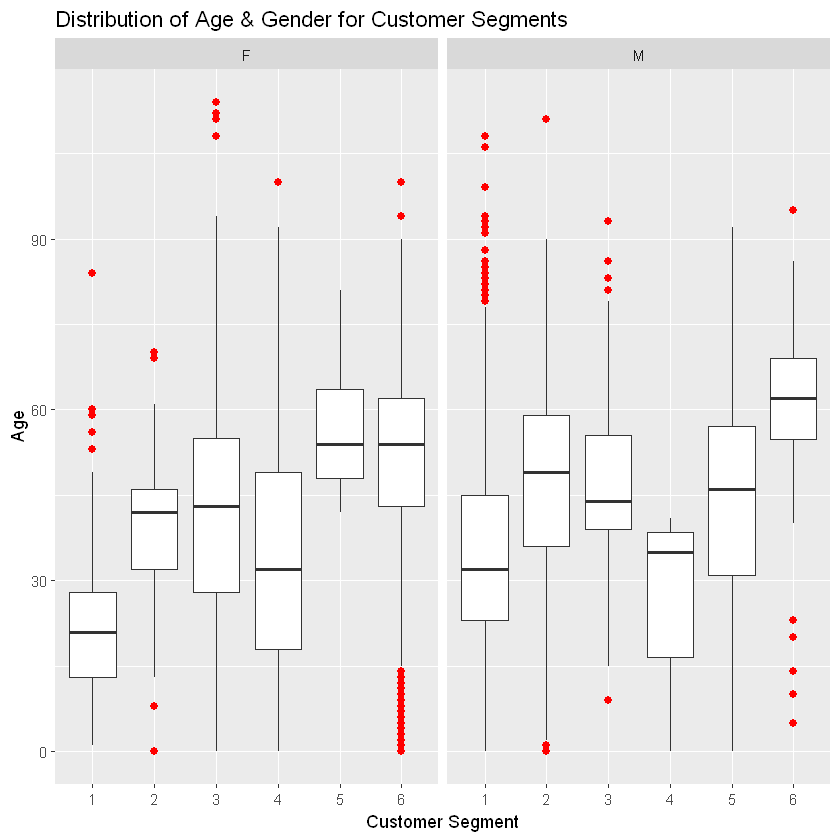

In [7]:
## Distributions for Age based on the customer segment - we see a lot of outliers

ggplot(suncountry, aes(x = cluster, y = Age)) +
        geom_boxplot(outlier.colour="red", outlier.size=2) + facet_grid(. ~ GenderCode) +
        labs(x="Customer Segment", title = "Distribution of Age & Gender for Customer Segments")

In [8]:
## Distributions of Final Destinations for Each Customer Segment

customer_segment_final_destination <- suncountry %>% 
        
        ## Group by the cluster and end city
        group_by(cluster, ServiceEndCity) %>%
        ## Count the number of times each end city appears
        summarise(id = n()) %>%
        ## Grab the top 10 final destinations for each to make for easier plotting
        top_n(10)

## Now we pivot the table a bit so that we organize by the final destinations for each segment - we'll use this in the next plot
final_dest_total_trips <- customer_segment_final_destination %>% 
        group_by(ServiceEndCity, cluster) %>%
        summarise(total_trips = sum(id))

Selecting by id


In [9]:
## Generate a table showing the grand total for each final desination

sorted_table <- final_dest_total_trips %>%
        group_by(ServiceEndCity) %>%
        summarise(grand_total = sum(total_trips)) %>%
        arrange(desc(grand_total))


levels = sorted_table$ServiceEndCity

## Re-arranging the sort order for our final destionation to help generate a more understandable graphic
final_dest_total_trips$ServiceEndCity <- factor(final_dest_total_trips$ServiceEndCity, levels = levels)

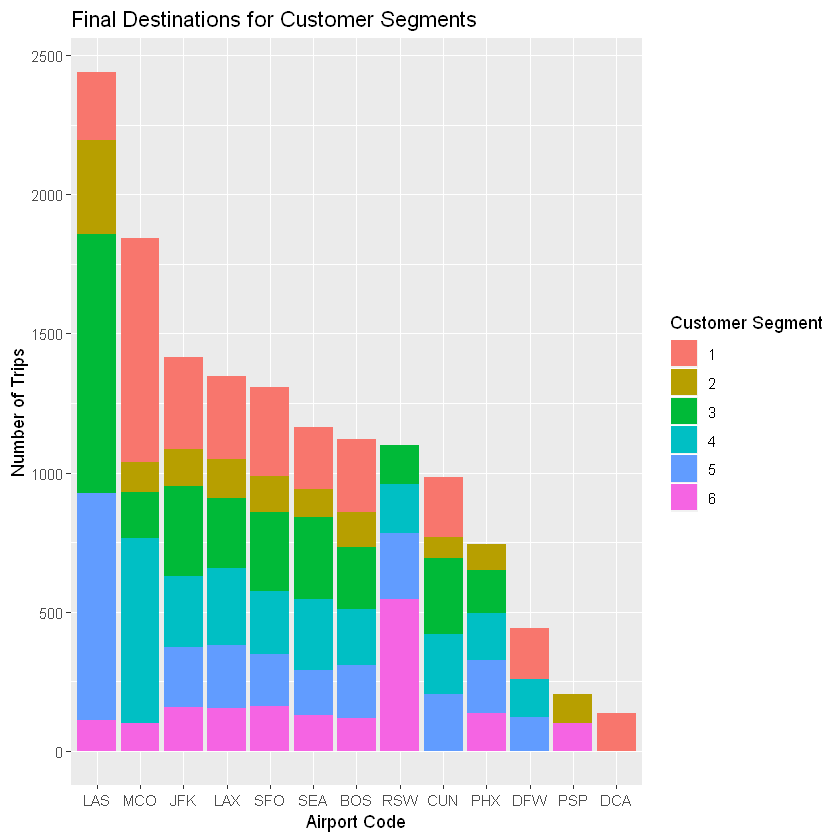

In [34]:
## Plot out the final desitinations for our identified customer segments

ggplot(final_dest_total_trips) +
        aes(x = ServiceEndCity, fill = cluster, weight = total_trips) +
        geom_bar() +
        scale_fill_hue() +
        labs(x = "Airport Code", y = "Number of Trips", title = "Final Destinations for Customer Segments", fill = "Customer Segment")

In [12]:
## Visualize how these flights were booked

## Group by booking channel and cluster

customer_segments_booking_channel <-
        suncountry %>%
                group_by(BookingChannel, cluster) %>%
                summarise(booking_count = n()) %>%
                arrange(desc(booking_count))

sorted_booking_channel <- customer_segments_booking_channel %>%
        group_by(BookingChannel) %>%
        summarise(grand_total = sum(booking_count)) %>%
        arrange((grand_total))

levels = sorted_booking_channel$BookingChannel

## Re-arranging the sort order for our final destionation to help generate a more understandable graphic
customer_segments_booking_channel$BookingChannel <- factor(customer_segments_booking_channel$BookingChannel, levels = levels)

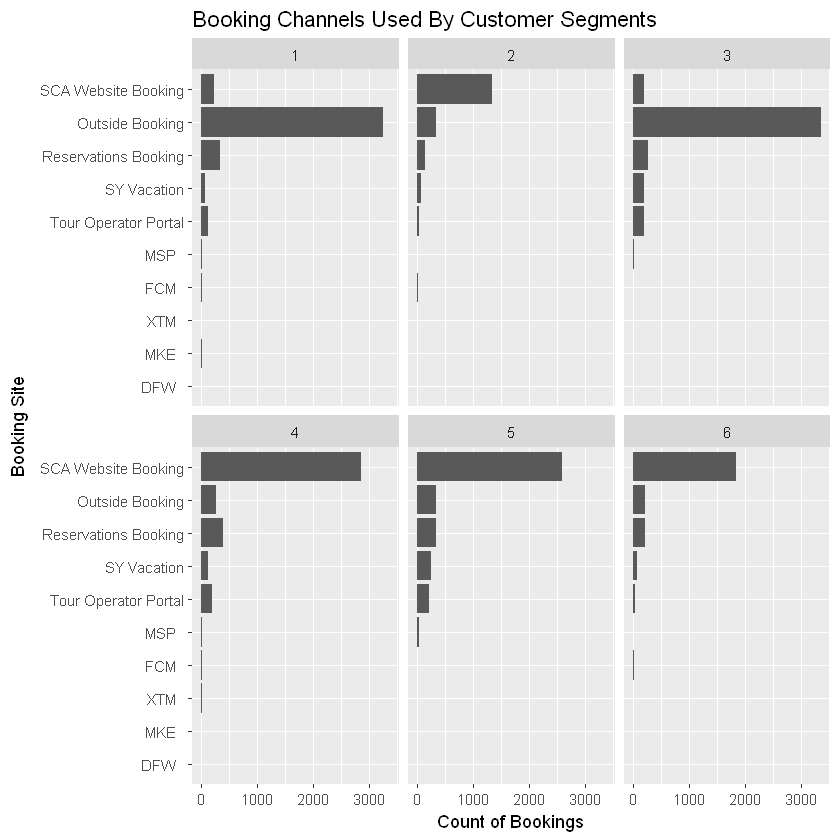

In [13]:
## Interesting observation - we see that customer segments 1 and 3 predominately used outside 
## booking channels
## Customer Segments 4 & 5 used the Sun Country website

ggplot(customer_segments_booking_channel) +
        aes(x = BookingChannel, weight = booking_count) +
        geom_bar() +
        scale_fill_hue() +
        coord_flip() +
        labs(x = "Booking Site", y = "Count of Bookings", title = "Booking Channels Used By Customer Segments", fill = "Customer Segment") +
        facet_wrap(cluster ~ .)

In [35]:
## Create a summary table for UFlyMembership - to identify which of our segments are actually 
## UFly members

customer_segment_ufly <-

suncountry %>%
        group_by(UflyMember, cluster) %>%
        summarise(grp_count = n()) %>%
        arrange(desc(grp_count))


## Convert UFlyMember column to factor variable
customer_segment_ufly$UflyMember <- as.factor(customer_segment_ufly$UflyMember)

customer_segment_ufly <-
        customer_segment_ufly %>%
                mutate(UflyMember_Factor = fct_recode(UflyMember,
                        "UFly Members" = "1",
                        "Potential UFly Members" = "0"))

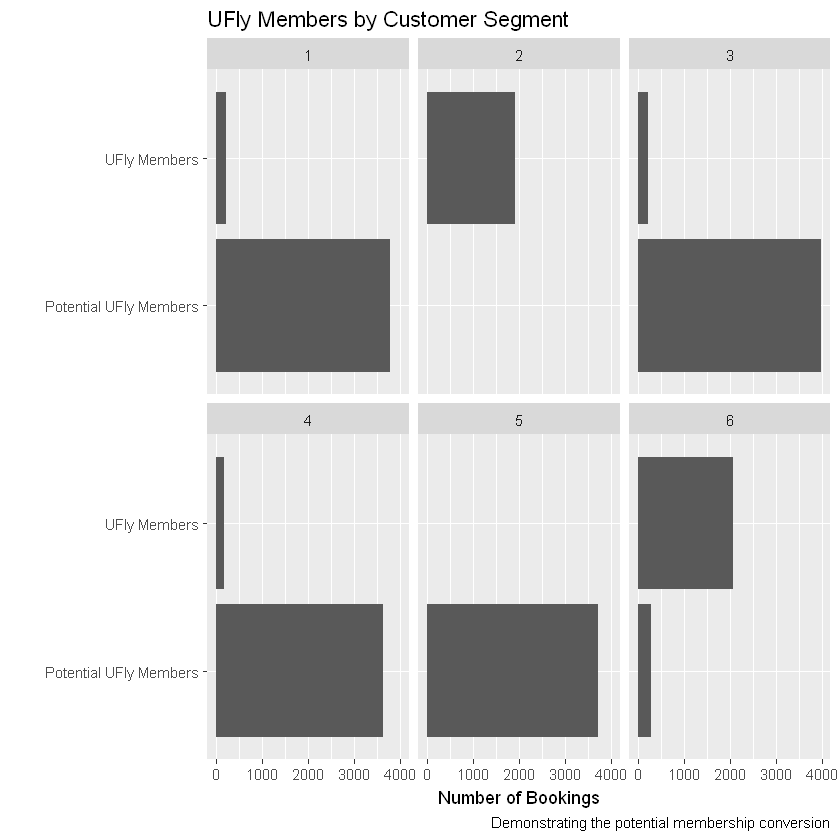

In [17]:
## Visualize UFly Membership for our customer segments - we see a lot of potential for membership!

ggplot(customer_segment_ufly) +
 aes(x = UflyMember_Factor, weight = grp_count) +
 geom_bar() +
 coord_flip() +
 labs(x = "", title = "UFly Members by Customer Segment", y = "Number of Bookings", caption = "Demonstrating the potential membership conversion") +
 theme_gray() +
 facet_wrap(vars(cluster))

In [18]:
## This code block contains the steps to demonstrate how to pre-process the entire dataset

## Takes about 5 minutes to load the three million row table


## data.dir = "C:/Users/monca016/Documents/Fall 2019/MSBA 6410 - Exploratory Analytics/HW2/"


## Set the file name
## data.file = "SunCountry.csv"

##  Subset the data based on 
## data = data %>% filter(MarketingAirlineCode == "SY") %>% select(TicketNum, PNRLocatorID, CouponSeqNbr, ServiceStartCity,ServiceEndCity, PNRCreateDate, ServiceStartDate, GenderCode,
   #             Age, PostalCode, BkdClassOfService, TrvldClassOfService, BookingChannel, BaseFareAmt, TotalDocAmt, UflyMemberStatus,
    #            CardHolder, BookedProduct, EnrollDate, StopoverCode)


## Remove any NULL/empty values from the data set
## data = na.omit(data)

## Update our data columns so they are Date fields - part of the cleanup
## data$PNRCreateDate = as.Date(data$PNRCreateDate)
## data$ServiceStartDate = as.Date(data$ServiceStartDate)

## Create trip month to filter on as well
## data$TripMonth = months.Date(data$ServiceStartDate)

In [19]:
## Filter on the clusters we care about investigating on the whole data set

target_clusters_subset <-
        suncountry %>%
                filter(cluster == 1 | cluster == 3 | cluster == 4 | cluster == 5)


## Bring together columns to use as a look-up

target_clusters_subset <- target_clusters_subset %>%
        unite(key, ServiceStartCity, ServiceEndCity, GenderCode, TripMonth, Age)


## Confirm the function combined the fields correctly

head(target_clusters_subset)

id,key,BookingChannel,TimeGap,UflyMember,CardHolderFlag,cluster
1,MSP_SAN_F_December_21,Outside Booking,27,0,0,1
3,MSP_SEA_F_December_63,Outside Booking,63,0,0,3
4,MSP_SEA_F_August_39,SCA Website Booking,63,0,0,4
5,MSP_ANC_F_July_25,Outside Booking,137,0,0,3
6,MSP_CUN_M_December_21,Outside Booking,24,0,0,1
7,MSP_MCO_M_December_39,Outside Booking,127,0,0,1


In [33]:
## 1.  Create a subset of the data based on that filter criteria
## We look up customers who took the same flights, at the same time of year, at the same age

## data_subset <- data %>%
   ##     filter(key %in% target_clusters_subset$key)

## 2.  Because all of the columns were merged together to form the key, we have split them out again

## data_subset <- 
    ##    data_subset %>%
      ##      separate(key, c("ServiceStartCity", "ServiceEndCity", "GenderCode", "TripMonth", "Age"))

## 3.  Looks like we have about 759,000 observations - way too much.
## We can whittle this down a little more by merging on the flight trips
## And only get one trip per passenger

## summary(data_subset)


## 4.  We use a function created to build out flight paths - 
## We'll leave this function out of the write-up
## But we can show a few of the lines in the function

## flight_legs <- function(dataframe_in) {
  
##  a <- dataframe_in %>% 
##  select(PNRLocatorID, TicketNum, CouponSeqNbr, ServiceStartCity, ServiceEndCity) %>% 
##  group_by(TicketNum) %>% mutate(trip_max = max(CouponSeqNbr))

##  a1 <- a %>% filter(CouponSeqNbr == 1) %>% 
##    select(PNRLocatorID, TicketNum, ServiceStartCity, ServiceEndCity, trip_max) %>% 
##    rename(City1 = ServiceStartCity, City2 = ServiceEndCity)
##  jx <- as_tibble(j5) %>% 
##    unite("Airport_Sequence", City1:City7, sep = "->", na.rm = TRUE)
    
##  jx <- jx[!duplicated(jx),]
  
##  return(jx)
## }


## 5.  Using our pre-built function, we can generate a "flight sequence" to determine the trip 
## locations for each passenger/trip

## 6.  For this step, we can filter on the first "ticket" for the trip, since we don't want duplicate rows

## df_seq1 <- data_subset %>% filter(CouponSeqNbr == 1) 
## fl_sequence <- left_join(df_seq1, flight_legs(data_subset), by = c("PNRLocatorID", "TicketNum"))


## 7.  Add in a few descriptive fields for final table - to mark if the customer is a UFly
## rewards member, and if they have the credit card

## fl_sequence$UflyMember = case_when(fl_sequence$UflyMemberStatus == "" ~ "Non-member",
##                                    fl_sequence$UflyMemberStatus != "" ~ "UFly Member")

## fl_sequence$CardHolderFlag = case_when(fl_sequence$CardHolder == "true" ~ "Card Holder",
##                                fl_sequence$CardHolder != "true" ~ "Non-card Holder")

## 8.  Create a list of columns that we want to subset on

## final_column_set <- c("ServiceStartCity", "ServiceEndCity", "GenderCode", "BkdClassOfService", 
## "TrvldClassOfService","TripMonth", "Age", "BookingChannel", "BaseFareAmt", 
## "Airport_Sequence", "UflyMember", "CardHolderFlag")

## 9.  Subset on the desired columns
## final_clean_output <- fl_sequence[, final_column_set]

## 10.  Remove duplicate rows from our target cluster subset of data

## remove_dups <- distinct(target_clusters_subset)

## 11.  We use a SQL query to pull the columns that we want and get the cluster
## information included as well

## final_summary_output <- 

## sqldf("SELECT f.ServiceStartCity, f.ServiceEndCity, f.GenderCode, 
## f.BkdClassOfService, f.TrvldClassOfService, f.TripMonth, f.Age,
## f.BookingChannel, f.BaseFareAmt, f.Airport_Sequence, f.UflyMember, f.CardHolderFlag, r.cluster
## from final_clean_output f
## INNER JOIN remove_dups r
## ON (f.ServiceStartCity = r.ServiceStartCity AND f.ServiceEndCity = r.ServiceEndCity 
## AND f.GenderCode = r.GenderCode AND f.TripMonth = r.TripMonth AND f.Age = r.Age)")

## 12.   Remove any duplicate rows generated from our SQL query, so we can start with a clean
##      unique data set

## final_summary_output <- distinct(final_summary_output)

## 13.  Last step - we save the output from this pre-processing as a CSV, so that we can easily read
##      it back and use it for our data tables below

## final_summary_output_as_csv <- write.csv(final_summary_output, 
##   file = "SunCountry_Summary_Output.csv")

In [22]:
## Read it back in as a CSV, since this is much faster than re-running our processing steps

final_summary_output <-read.csv("SunCountry_Summary_Output.csv")

In [23]:
## View some summary statistics - No NAs!  Thats great!

summary(final_summary_output)

       id         ServiceStartCity ServiceEndCity   GenderCode
 Min.   :     1   MSP:533596       LAS    :106229   F:282697  
 1st Qu.:133400                    MCO    : 72553   M:250898  
 Median :266799                    JFK    : 46403   U:     1  
 Mean   :266799                    SFO    : 41271             
 3rd Qu.:400197                    LAX    : 38705             
 Max.   :533596                    BOS    : 31781             
                                   (Other):196654             
            BkdClassOfService            TrvldClassOfService    TripMonth     
 Coach               :516775   Coach               :483851   March   : 79354  
 Discount First Class:   161   Discount First Class: 14774   February: 53633  
 First Class         : 16660   First Class         : 34971   July    : 48674  
                                                             December: 47985  
                                                             June    : 45929  
                      

In [24]:
## Look at the first few rows to see a nice, clean dataset

head(final_summary_output)

id,ServiceStartCity,ServiceEndCity,GenderCode,BkdClassOfService,TrvldClassOfService,TripMonth,Age,BookingChannel,BaseFareAmt,Airport_Sequence,UflyMember,CardHolderFlag,cluster
1,MSP,JFK,M,Coach,Coach,August,31,Outside Booking,0.00,MSP->JFK,Non-member,Non-card Holder,1
2,MSP,JFK,M,Coach,Coach,August,31,Outside Booking,0.00,MSP->JFK,Non-member,Non-card Holder,5
3,MSP,SFO,F,Coach,Coach,December,45,Outside Booking,240.93,MSP->SFO,Non-member,Non-card Holder,3
4,MSP,LAS,F,Coach,Coach,September,43,Outside Booking,305.12,MSP->LAS,Non-member,Non-card Holder,3
5,MSP,LAS,F,Coach,Discount First Class,September,56,SCA Website Booking,199.07,MSP->LAS,UFly Member,Card Holder,3
6,MSP,JFK,F,Coach,Coach,July,31,Outside Booking,0.00,MSP->JFK,Non-member,Non-card Holder,3


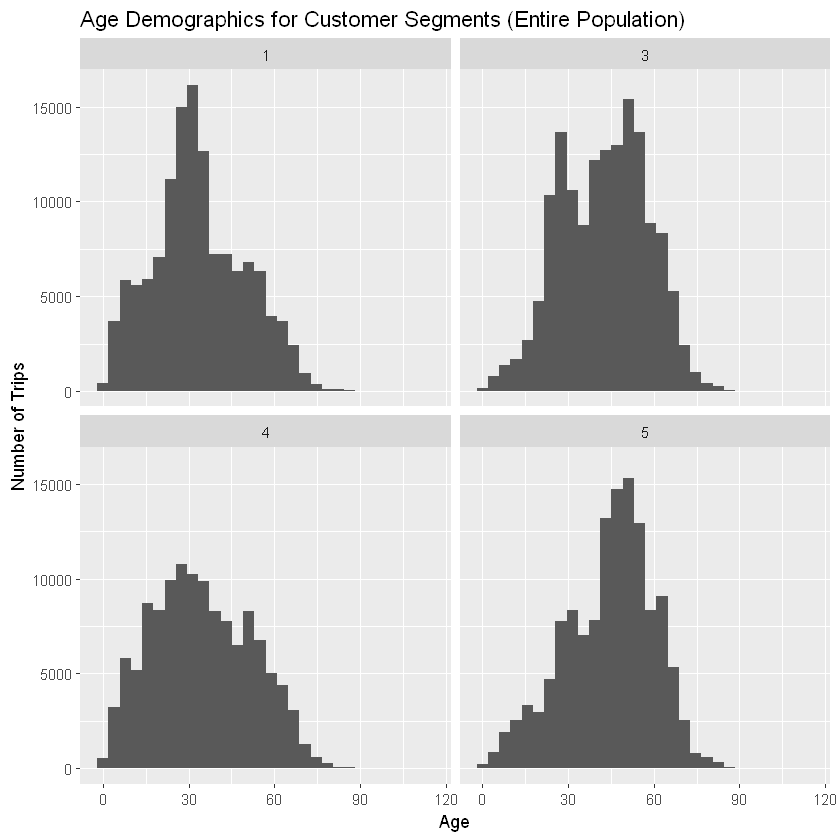

In [117]:
ggplot(data = final_summary_output, aes(final_summary_output$Age)) + 
    geom_histogram(bins = 30) + 
    facet_wrap(. ~ cluster) +
    labs(x = "Age", y = "Number of Trips", title = "Age Demographics for Customer Segments (Entire Population)")

## Characteristics of UFly Reward members

In [49]:
## Create a subset of our clustered data, combined with the full data set
## Filter on UFlyMembers and customer segment five

customer_segment_five <-

final_summary_output %>%
    filter(UflyMember == "UFly Member") %>%
    filter(cluster == 5)

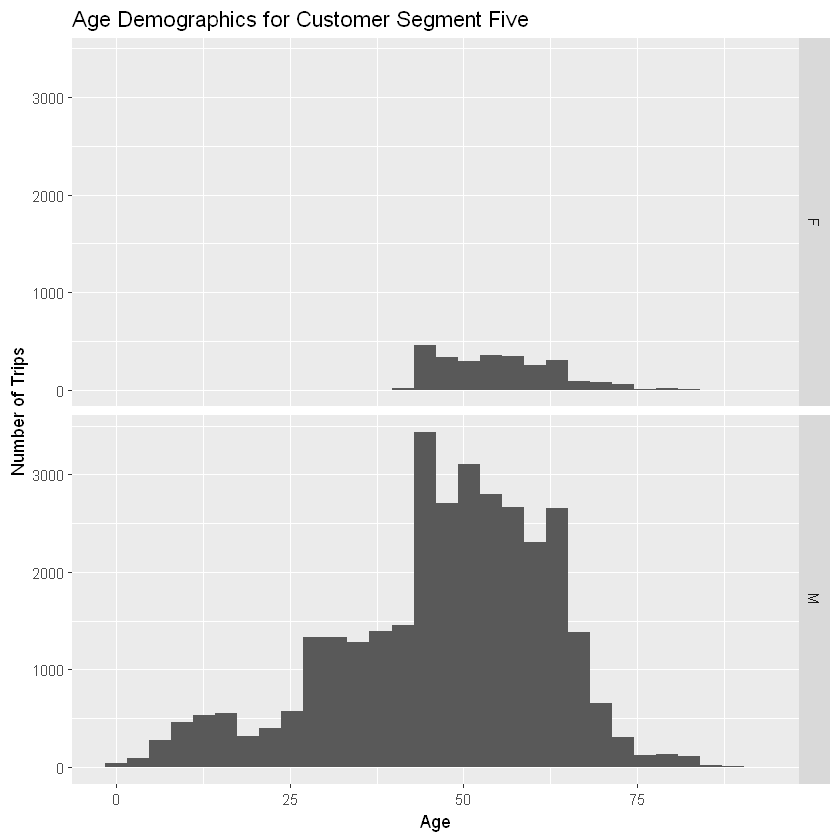

In [77]:
## Generate a plot to view Age and Gender demographics for customer segment five

ggplot(data = customer_segment_five, aes(customer_segment_five$Age)) + 
    geom_histogram(bins = 30) + 
    labs(x = "Age", y = "Number of Trips", title = "Age Demographics for Customer Segment Five") +
    facet_grid(GenderCode ~ .)

In [87]:
## Segment on customer booking information and where they were flying to

customer_segment_five_booking_info <-

customer_segment_five %>%
        group_by(BookingChannel, BkdClassOfService, GenderCode, Age) %>%
        summarise(trip_count = n()) %>%
        top_n(10) %>%
        arrange(desc(trip_count))


## Create a quick analysis to sort our booking channel information for easier viewing

sorted_table <- customer_segment_five_booking_info %>%
        group_by(BookingChannel) %>%
        summarise(grand_total = sum(trip_count)) %>%
        arrange(grand_total)


levels = sorted_table$BookingChannel

## Re-arranging the sort order for our final destionation to help generate a more understandable graphic
customer_segment_five_booking_info$BookingChannel <- factor(customer_segment_five_booking_info$BookingChannel, levels = levels)

Selecting by trip_count


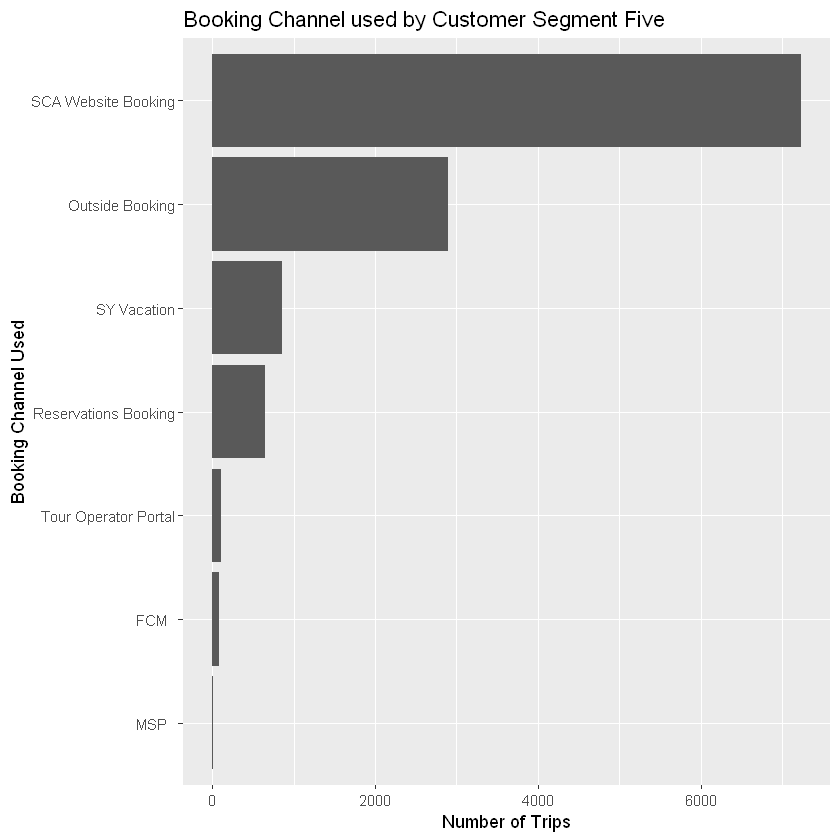

In [110]:
## Generate a plot to visualize what booking channel was used by this segment

ggplot(customer_segment_five_booking_info) +
        aes(x = BookingChannel, fill = Age, weight = trip_count) +
        geom_bar() +
        scale_fill_hue() +
        coord_flip() +
        labs(x = "Booking Channel Used", y = "Number of Trips", title = "Booking Channel used by Customer Segment Five", fill = "Customer Segment")

In [114]:
## Where are our identified UFlyMembers flying?

customer_segment_five_trip_info <-

customer_segment_five %>%
        group_by(TripMonth, Airport_Sequence, GenderCode) %>%
        summarise(trip_count = n()) %>%
        top_n(10) %>%
        arrange(desc(trip_count))

head(customer_segment_five_trip_info)

Selecting by trip_count


TripMonth,Airport_Sequence,GenderCode,trip_count
March,MSP->RSW,M,1557
October,MSP->LAS,M,1253
March,MSP->LAS,M,1065
May,MSP->LAS,M,950
November,MSP->LAS,M,900
January,MSP->LAS,M,861


In [66]:
## Create a function to order the trip locations correctly needed for our plot

airport_sorted_table <- customer_segment_five_trip_info %>%
        group_by(Airport_Sequence) %>%
        summarise(grand_total = sum(trip_count)) %>%
        arrange(grand_total)


airport_levels = airport_sorted_table$Airport_Sequence

## Re-arranging the sort order for our final destionation to help generate a more understandable graphic
customer_segment_five_trip_info$Airport_Sequence <- factor(customer_segment_five_trip_info$Airport_Sequence, levels = airport_levels)

ERROR: Error in eval(lhs, parent, parent): object 'customer_segment_five_trip_info' not found


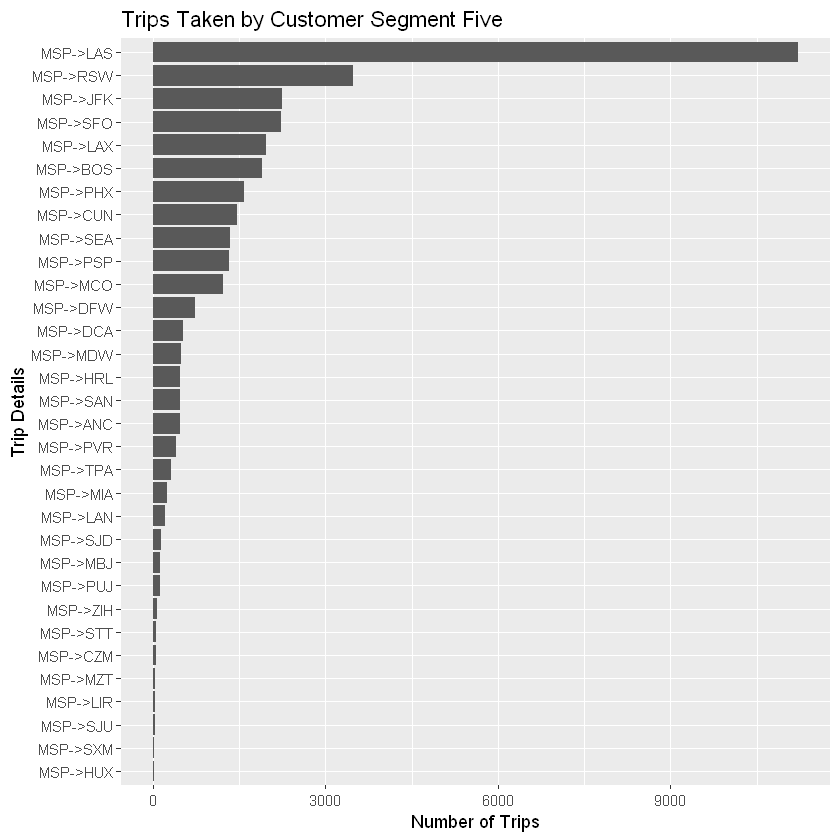

In [116]:
## Generate a plot to demonstrate where customers in this segment are flying

ggplot(customer_segment_five_trip_info) +
        aes(x = Airport_Sequence, weight = trip_count) +
        geom_bar() +
        scale_fill_hue() +
        coord_flip() +
        labs(x = "Trip Details", y = "Number of Trips", title = "Trips Taken by Customer Segment Five", fill = "Customer Segment")

In [64]:
## Create a function to order the months correctly needed for our plot

month_levels = c("January", "February", "March", "April", "May", "June", "July", "August", "September",
          "October", "November", "December")

## Re-arranging the sort order for our trip months to help generate a more understandable graphic
customer_segment_five_trip_info$TripMonth <- factor(customer_segment_five_trip_info$TripMonth, levels = rev(month_levels))

ERROR: Error in factor(customer_segment_five_trip_info$TripMonth, levels = rev(month_levels)): object 'customer_segment_five_trip_info' not found


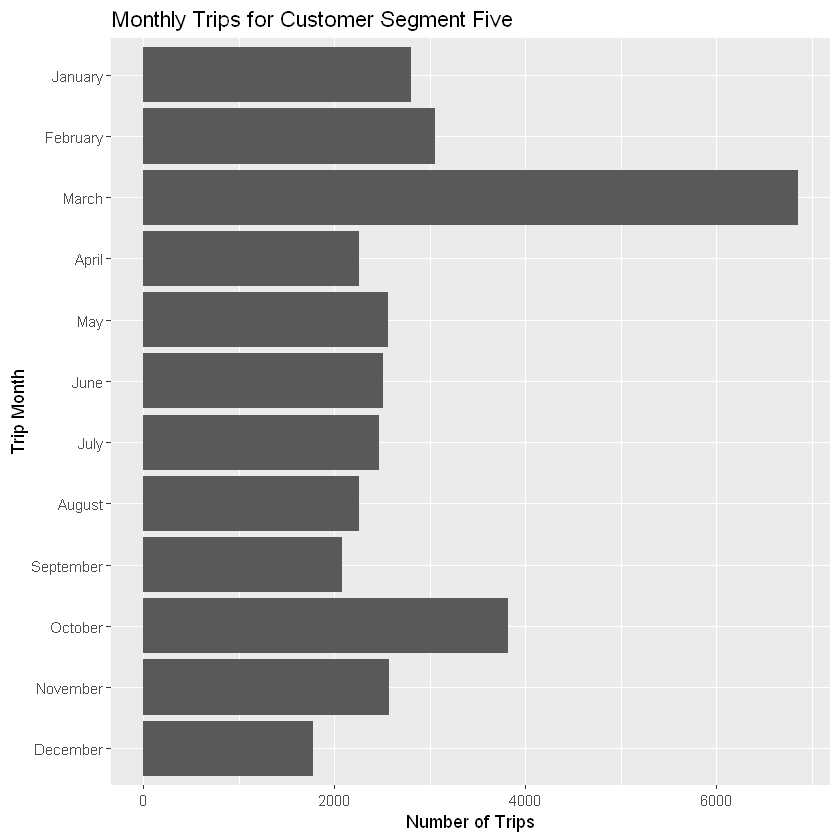

In [108]:
## Generate a plot to get a sense of when our travelers are flying

ggplot(customer_segment_five_trip_info) +
        aes(x = TripMonth, weight = trip_count) +
        geom_bar() +
        scale_fill_hue() +
        coord_flip() +
        labs(x = "Trip Month", y = "Number of Trips", title = "Monthly Trips for Customer Segment Five", fill = "Customer Segment")

# Conclusions

# Recommendations

Methods to encourage people to sign up for Ufly Rewards

Methods to encourage booking on the Sun Country Website

Specifically address the MSP -> Vegas older men


(I think the knit process creates the contents - probably delete this block)
Contents

Problem Statement and Approach What are Sun Countries Objectives? UFly Rewards SCA Booking

Data Preparation insert steps we did to clean and process the data

Exploratory Analysis of the Sun Country Flight Data Simple exploratory analysis of the FULL data set

Clustering Strategies Towards Customer Segmentation

    Characteristics of UFly Reward members
    Characteristics of Fliers

Conclusions This is where we put conclusions from the above

Recommendations
Problem Statement and our Approach

Sun Countries Objectives

In order to compete with major airline firms, Sun Country Airlines needs to be savvy and sophisticated in their marketing and customer interaction strategy. Sun Countries Ufly reward program and digital experience provide Sun Country a platform in which to enable modern marketing and analytics techniques to create value to enable Sun Country to compete with other, more resource enabled, airline firms. Leveraging exploratory analytics techniques, such as clustering analysis, will enable Sun Country to generate insights and actionable hypotheses from the data. Examining the characteristics of customer cohorts and their flying habits will help Sun Counry focus their strategic initiatives to delivering best in class service and options to the Sun Country customer base.

Our Approach

We propose a customer segmentation analytics approach to guide the exploration of customer characteristics and how they travel. Specifically, we choose to explore the portion of customer who use the Minneapolis - St.Paul Sun Country hub as their start point for their journeys, as coded in the data. We then leverage a k-medioids approach to cluster mixed data-types. This partioning around mediods algorithm leverages Gower distance to appropriately compute partial dissimilarities and is very intuitive. It also has an extremely useful feature in that it can produce statistics around what a typical customer might look like for each cluster, allowing us to see who is, or isn't, traveling with a UFly membership or booking through the SCA site.
Data Preparation

missing values segments to trips working with samples
Exploratory Analysis of the Sun Country Flight Data

We found # Clusters - brief description

One particular cluster of interest was Men in their 50's who fly from Minneapolis to Las Vegas in coach, booking via the Sun Country Website, that are not Ufly Rewards members or credit card holders. Minneapolis to Las Vegas is a very popular flight for Sun Country and is offered frequently and this group of flyers in particular stands out. This customer segment is already booking through the website so an extra push to get them to be Ufly Rewards members may help to get them to make more trips on Sun Country.
Clustering Strategies Towards Customer Segmentation

some text here explaining the clustering techniques again

1.) Defining the characteristics of UFly reward fliers

2.) Defining the characteristics of flights booked through the SCA site
Conclusions
Recommendations

Methods to encourage people to sign up for Ufly Rewards

Methods to encourage booking on the Sun Country Website

Specifically address the MSP -> Vegas older men
